# 1. Importing Libraries & Loading Data

## 1.x. Installing Libraries and Modules

In [1]:
# Note: No need to run the cell if you have installed the ff. libraries or frameworks.
# Note: Hide the cells by clicking the arrow button beside the markdown.

In [1]:
#!pip install pandas
#!pip install numpy
#!pip install matplotlib
#!pip install opencv-python
#!pip install tqdm
#!pip install seaborn
#!pip install joblib
#!pip install scikit-learn
#!pip install imageio
#!pip install tensorflow
#!pip install pillow

## 1.x. Importing Libraries and Modules

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
import os 
import cv2
from tqdm import tqdm 
import seaborn as sns
import joblib 
import warnings
import math
import pickle as pk
import datetime
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from imageio import imread
import imageio
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers,Model,Sequential
from tensorflow.keras.layers import Dropout,Activation,InputLayer,LSTM,GRU,Bidirectional,TimeDistributed,Flatten,Dense,BatchNormalization,MaxPooling2D,Conv2D,Input,Concatenate,LeakyReLU
warnings.filterwarnings('ignore')
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.layers import concatenate, add
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing import image_dataset_from_directory, image # new
from PIL import Image
from pathlib import Path
import imghdr
import shutil
import random

## 1.x. Getting a Sample from the CASIA v2.0 Dataset

### Run IFL-3_UNET_ds.ipynb

In [23]:
# Run the IFL-3_UNET_ds.ipynb notebook to get a sample from the dataset.
# Verify the following folders with their corresponding no. of images:
    # train_set
      # tp_trainset, 200 images - mix of .jpeg and .tif files
      # tp_mask_trainset, 200 images - all .png files
    # val_set
      # tp_valset, 50 images - mix of .jpeg and .tif files

In [24]:
# tp_trainset gets the first 200 images from the Tp folder of CASIA v2.0
   # tp_mask_trainset is the corresponding groundtruth masks (targets) of tp_trainset's images
# tp_valset randomly gets 50 images from the Tp folder of CASIA v2.0 - which is distinct from the ones in tp_trainset

In [25]:
# Destination directories
tp_ts = "train_set/tp_trainset"
tp_vs = "val_set/tp_valset"
tp_mask_ts = "train_set/tp_mask_trainset"

### 1.x. Checking tp_ts

In [26]:
#Sample files names in Tp images
os.listdir(tp_ts)[:5]

['Tp_D_CND_M_N_ani00018_sec00096_00138.tif',
 'Tp_D_CND_M_N_art00076_art00077_10289.tif',
 'Tp_D_CND_M_N_art00077_art00076_10290.tif',
 'Tp_D_CND_S_N_ani00073_ani00068_00193.tif',
 'Tp_D_CND_S_N_ind00078_ind00077_00476.tif']

In [9]:
# List of filenames in Tp images directory
tp_files = os.listdir(tp_ts)
print("Number of Images in tp_ts folder:", len(tp_files)) #800

Number of Images in tp_ts folder: 800


### 1.x. Checking tp_mask_ts

In [10]:
#Sample files names in Tp images
os.listdir(tp_mask_ts)[:5]

['Tp_D_CND_M_N_ani00018_sec00096_00138_gt.png',
 'Tp_D_CND_M_N_art00076_art00077_10289_gt.png',
 'Tp_D_CND_M_N_art00077_art00076_10290_gt.png',
 'Tp_D_CND_S_N_ani00073_ani00068_00193_gt.png',
 'Tp_D_CND_S_N_ind00078_ind00077_00476_gt.png']

In [11]:
# List of filenames in Tp images directory
tp_files = os.listdir(tp_mask_ts)
print("Number of Images in tp_mask_ts folder:", len(tp_files)) #800

Number of Images in tp_mask_ts folder: 800


### 1.x. Checking tp_vs

In [12]:
#Sample files names in Tp images
os.listdir(tp_vs)[:5]

['Tp_D_CNN_M_N_ani00023_ani00024_10205.tif',
 'Tp_D_CNN_S_N_cha10194_cha10192_12323.jpg',
 'Tp_D_CRD_M_N_art00058_art00051_10534.tif',
 'Tp_D_CRN_M_N_ani10101_ani00081_10139.tif',
 'Tp_D_CRN_M_N_art00067_nat00059_11805.jpg']

In [13]:
# List of filenames in Tp images directory
tp_files = os.listdir(tp_vs)
print("Number of Images in tp_vs folder:", len(tp_files)) #200

Number of Images in tp_vs folder: 200


# 2. Preprocessing

In [14]:
# Note: No need to run the section if you have the images preprocessed already.
# Note: To verify if you have preprocessed the images, check the destination directory folders: tp_trainset and tp_valset - if they're resized accordingly.

## 2.x. tp_ts& tp_vs: Normalizing Pixel Values

In [16]:
def px_normalization(directory):
    # Get list of image files in the directory
    image_files = [f for f in os.listdir(directory) if f.endswith((".jpg", ".png", ".tif"))]
    
    # Iterate through each image file in the directory with tqdm progress bar
    for filename in tqdm(image_files, desc="Normalizing images"):
        # Read the image
        img_path = os.path.join(directory, filename)
        img = cv2.imread(img_path)
        
        # Convert color format to RGB for TIFF images
        if filename.endswith(".tif"):
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # Ensure the image is in the correct data type and range
        img = img.astype('float32')  # Convert to float32
        img = img / 255.0  # Normalize pixel values
        
        # Convert color format back to BGR for JPEG images
        if filename.endswith(".tif"):
            img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        
        # Convert back to uint8 data type
        img = (img * 255).astype('uint8')
        
        # Overwrite the original image with the normalized image
        cv2.imwrite(img_path, img)

In [17]:
# Normalize pixel values in the training set
px_normalization(tp_ts) #800

Normalizing images: 100%|███████████████████████████████████████████████████████████| 800/800 [00:05<00:00, 151.51it/s]


In [18]:
# Normalize pixel values in the validation set
px_normalization(tp_vs) #200

Normalizing images: 100%|███████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 132.64it/s]


## 2.x. tp_mask_ts: Normalizing & Binarizing Pixel Values

In [19]:
def bin_norm_gt_masks(mask_dir):
    # Get the list of all files in the directory
    mask_files = [f for f in os.listdir(mask_dir) if os.path.isfile(os.path.join(mask_dir, f))]

    for mask_file in tqdm(mask_files, desc="Binarizing and Normalizing Ground Truth Masks"):
        mask_path = os.path.join(mask_dir, mask_file)
        
        # Read the mask image
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        
        if mask is None:
            continue  # Skip if the mask cannot be read
            print("I cannot be read.")
        
        # Binarize the mask: ensure pixel values are 0 or 1
        _, binarized_mask = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)
        
        # Normalize the mask to have pixel values between 0 and 1
        normalized_mask = binarized_mask / 255.0
        
        # Save the normalized mask back to the same path
        cv2.imwrite(mask_path, (normalized_mask * 255).astype(np.uint8))

In [20]:
bin_norm_gt_masks(tp_mask_ts)

Binarizing and Normalizing Ground Truth Masks: 100%|████████████████████████████████| 800/800 [00:01<00:00, 438.19it/s]


## 2.x. Tp: Image Standardization (256x256x3)

In [21]:
# Q: Why are we resizing the images to 256x256x3?
# A: From the original 512x512x3, we are resizing the images to 256x256x3 to reduce the computational complexity of the model.

# Q: Can the U-Net accept the image if it is not in 256x256x3?
# A: No.

In [22]:
def resize_and_convert_images(directory):
    # Get list of files in the directory
    files = os.listdir(directory)
    
    # Iterate over the files
    for file in tqdm(files, desc="Resizing and Converting Images", unit="image"):
        # Construct file path
        file_path = os.path.join(directory, file)
        
        # Open image using PIL
        image = Image.open(file_path)
        
        # Resize image to 256x256
        image = image.resize((256, 256))
        
        # Convert image to RGB if it's not already in RGB format
        if image.mode != "RGB":
            image = image.convert("RGB")
        
        # Overwrite the original image with the resized and converted image
        image.save(file_path)

In [23]:
# Resize and convert images in train set directory
resize_and_convert_images(tp_ts)

Resizing and Converting Images: 100%|████████████████████████████████████████████| 800/800 [00:05<00:00, 150.23image/s]


In [24]:
# Resize and convert images in validation set directory
resize_and_convert_images(tp_vs)

Resizing and Converting Images: 100%|████████████████████████████████████████████| 200/200 [00:01<00:00, 145.44image/s]


## 2.x. Gt: Image Standardization (256x256x1)

In [25]:
# Note: No need to run the section if you have the images preprocessed already.
# Note: To verify if you have preprocessed the images, check the destination directory folders: tp_trainset and tp_valset - if they're resized accordingly.

In [26]:
# Q: Why are we resizing the images to 256x256x1?
# A: Groundtruth (Gt) Images will serve as the targets of our model. Channel is '1' since Gt images are in grayscale - meaning pixels could either be 1s or 0s, authentic or tampered.

In [27]:
def resize_groundtruth_images(directory):
    # Get list of files in the directory
    files = os.listdir(directory)
    
    # Iterate over the files
    for file in tqdm(files, desc="Resizing Groundtruth Images", unit="image"):
        # Construct file path
        file_path = os.path.join(directory, file)
        
        # Open image using PIL
        image = Image.open(file_path)
        
        # Resize image to 256x256
        image = image.resize((256, 256))
        
        # Convert image to grayscale if it's not already in grayscale format
        if image.mode != "L":
            image = image.convert("L")
        
        # Overwrite the original image with the resized image
        image.save(file_path)

In [28]:
# Destination directory
tp_mask_ts = "train_set/tp_mask_trainset"

In [29]:
# Resize groundtruth images
resize_groundtruth_images(tp_mask_ts)

Resizing Groundtruth Images: 100%|███████████████████████████████████████████████| 800/800 [00:03<00:00, 206.35image/s]


## 2.x. Converting Images to Arrays (tp_ts & tp_vs)

In [30]:
# Note: No need to run the section if you have the images preprocessed already.

In [31]:
# Q: Why convert the images to arrays?
# A: Compatibility with Neural Networks: Deep learning frameworks like TensorFlow and PyTorch typically expect inputs in the form of numerical arrays.
# A: It is a fundamental step in preparing data for deep learning models.

In [32]:
def images_to_arrays(directory):
    # Get list of files in the directory
    files = os.listdir(directory)
    
    # Initialize an empty list to store image arrays
    image_arrays = []
    
    # Iterate over the files
    for file in tqdm(files, desc="Converting Images to Arrays", unit="image"):
        # Construct file path
        file_path = os.path.join(directory, file)
        
        # Open image using PIL
        image = Image.open(file_path)
        
        # Convert image to numpy array
        image_array = np.array(image)
        
        # Append image array to list
        image_arrays.append(image_array)
    
    # Convert list of image arrays to numpy array
    image_arrays = np.array(image_arrays)
    
    return image_arrays

In [33]:
# Convert images to arrays for train set
tp_ts_arrays = images_to_arrays(tp_ts)
print("Train Set Arrays Shape:", tp_ts_arrays.shape) # Shape: 200, 256, 256, 3

Converting Images to Arrays: 100%|███████████████████████████████████████████████| 800/800 [00:03<00:00, 225.22image/s]

Train Set Arrays Shape: (800, 256, 256, 3)


In [34]:
# Convert images to arrays for validation set
tp_vs_arrays = images_to_arrays(tp_vs)
print("Validation Set Arrays Shape:", tp_vs_arrays.shape) # Shape: 50, 256, 256, 3

Converting Images to Arrays: 100%|███████████████████████████████████████████████| 200/200 [00:00<00:00, 221.17image/s]


Validation Set Arrays Shape: (200, 256, 256, 3)


## 2.x. Converting Gt Images to Arrays (tp_mask_ts)

In [35]:
# Convert images to arrays for train set's targets
tp_mask_ts_arrays = images_to_arrays(tp_mask_ts)
print("Train Set Arrays Shape:", tp_mask_ts_arrays.shape) # Shape: 200, 256, 256

Converting Images to Arrays: 100%|███████████████████████████████████████████████| 800/800 [00:02<00:00, 326.21image/s]

Train Set Arrays Shape: (800, 256, 256)


## 2.x. Data Type Checking, Conversion, & Standardization

In [36]:
# Check current dtype
print("Current dtype of tp_ts_arrays:", tp_ts_arrays.dtype)
print("Current dtype of tp_vs_arrays:", tp_vs_arrays.dtype)
print("Current dtype of tp_mask_ts_arrays:", tp_mask_ts_arrays.dtype)

Current dtype of tp_ts_arrays: uint8
Current dtype of tp_vs_arrays: uint8
Current dtype of tp_mask_ts_arrays: uint8


In [37]:
def convert_dtype(array, dtype=np.uint8):
    # Convert data type of array
    return array.astype(dtype)

In [38]:
# Convert arrays to the desired data type
tp_ts_arrays = convert_dtype(tp_ts_arrays)
tp_vs_arrays = convert_dtype(tp_vs_arrays)
tp_mask_ts_arrays = convert_dtype(tp_mask_ts_arrays)

In [39]:
# Print new datatype
print("New dtype of tp_ts_arrays:", tp_ts_arrays.dtype) # uint8
print("New dtype of tp_vs_arrays:", tp_vs_arrays.dtype) # uint8
print("New dtype of tp_mask_ts_arrays:", tp_mask_ts_arrays.dtype) # uint8

New dtype of tp_ts_arrays: uint8
New dtype of tp_vs_arrays: uint8
New dtype of tp_mask_ts_arrays: uint8


# 3. Train Test Split

In [208]:
def load_images_and_masks(directory):
    files = os.listdir(directory)
    data = []
    for file in files:
        file_path = os.path.join(directory, file)
        image = Image.open(file_path)
        data.append(np.array(image))
    return data

In [209]:
# Source directories
tp_trainset_dir = "train_set/tp_trainset"
tp_mask_trainset_dir = "train_set/tp_mask_trainset"

In [210]:
# Load tampered images and masks
tp_trainset = load_images_and_masks(tp_trainset_dir)
tp_mask_trainset = load_images_and_masks(tp_mask_trainset_dir)

In [211]:
# Concatenate images and masks into a single array
X = np.array(tp_trainset) # training images
y = np.array(tp_mask_trainset) # corresponding masks, targets

In [212]:
# Split the data into train and test sets, stratified by y (masks)
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2, 
                                                    random_state=42)

In [213]:
# Print shapes of train and test sets
print("X_train shape:", X_train.shape)  # (640, 256, 256, 3)
print("X_test shape:", X_test.shape)    # (160, 256, 256, 3)
print("y_train shape:", y_train.shape)  # (640, 256, 256)
print("y_test shape:", y_test.shape)    # (160, 256, 256)

X_train shape: (640, 256, 256, 3)
X_test shape: (160, 256, 256, 3)
y_train shape: (640, 256, 256)
y_test shape: (160, 256, 256)


# 4. Model Implementation

## 4.x. Implementing the Pre-Trained U-Net Model

In [27]:
# Define input tensor shape (256x256x3)
input_img = Input((256, 256, 3))

In [28]:
def conv2d_block(input_tensor, n_filters, kernel_size=3, batchnorm=True):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = tf.keras.layers.Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size),
                                kernel_initializer='he_normal', padding='same')(input_tensor)
    if batchnorm:
        x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)

    # second layer
    x = tf.keras.layers.Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size),
                                kernel_initializer='he_normal', padding='same')(x)
    if batchnorm:
        x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)

    return x

In [29]:
def get_unet(input_img, n_filters=16, dropout=0.1, batchnorm=True):
    """Function to define the UNET Model"""
    # Contracting Path
    c1 = conv2d_block(input_img, n_filters * 1, kernel_size=3, batchnorm=batchnorm)
    p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)
    # p1 = tf.keras.layers.Dropout(dropout)(p1)

    c2 = conv2d_block(p1, n_filters * 2, kernel_size=3, batchnorm=batchnorm)
    p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)
    # p2 = tf.keras.layers.Dropout(dropout)(p2)

    c3 = conv2d_block(p2, n_filters * 4, kernel_size=3, batchnorm=batchnorm)
    p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)
    # p3 = tf.keras.layers.Dropout(dropout)(p3)

    c4 = conv2d_block(p3, n_filters * 8, kernel_size=3, batchnorm=batchnorm)
    p4 = tf.keras.layers.MaxPooling2D((2, 2))(c4)
    p4 = tf.keras.layers.Dropout(dropout)(p4)

    # Bottleneck
    c5 = conv2d_block(p4, n_filters * 16, kernel_size=3, batchnorm=batchnorm)

    # Expansive Path
    u6 = tf.keras.layers.Conv2DTranspose(n_filters * 8, (3, 3), strides=(2, 2), padding='same')(c5)
    u6 = tf.keras.layers.concatenate([u6, c4])
    c6 = conv2d_block(u6, n_filters * 8, kernel_size=3, batchnorm=batchnorm)

    u7 = tf.keras.layers.Conv2DTranspose(n_filters * 4, (3, 3), strides=(2, 2), padding='same')(c6)
    u7 = tf.keras.layers.concatenate([u7, c3])
    c7 = conv2d_block(u7, n_filters * 4, kernel_size=3, batchnorm=batchnorm)

    u8 = tf.keras.layers.Conv2DTranspose(n_filters * 2, (3, 3), strides=(2, 2), padding='same')(c7)
    u8 = tf.keras.layers.concatenate([u8, c2])
    c8 = conv2d_block(u8, n_filters * 2, kernel_size=3, batchnorm=batchnorm)

    u9 = tf.keras.layers.Conv2DTranspose(n_filters * 1, (3, 3), strides=(2, 2), padding='same')(c8)
    u9 = tf.keras.layers.concatenate([u9, c1])
    c9 = conv2d_block(u9, n_filters * 1, kernel_size=3, batchnorm=batchnorm)

    outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)
    model = tf.keras.models.Model(inputs=[input_img], outputs=[outputs])
    return model

In [30]:
# Build U-Net model with specified parameters
model_unet = get_unet(
    input_img,         # Input image tensor
    n_filters=16,      # Default no. of filters in the convolutional layers
    dropout=0.05,      # Default dropout rate
    batchnorm=True     # Whether to use batch normalization, set to True
)

In [31]:
# Freeze layers
# for layer in model_unet.layers[:7]:
    #layer.trainable = False

## 4.x. Model Callbacks

In [32]:
# Path where checkpoints will be saved
checkPoint_path = "checkpoints_newnet"

In [33]:
# Defining file path pattern for saving model weights
filepath = os.path.join(checkPoint_path, "weights-improvement-{val_accuracy:.2f}.keras")

In [34]:
# Defining a ModelCheckpoint callback to save the best model weights based on validation accuracy
checkpoint = ModelCheckpoint(
    filepath,                      # File path pattern for saving model weights
    monitor='val_accuracy',        # Metric to monitor for saving the best model
    verbose=1,                     # Verbosity mode (1: print updates, 0: silent)
    save_best_only=True,           # Save only the best model based on the monitored metric
    mode='max'                     # Mode for optimizing the monitored metric (max: maximize accuracy)
)

In [35]:
# Path for TensorBoard logs
log_dir = os.path.join("logs_newnet", "model_logs_newnet_" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [36]:
# Define a TensorBoard callback to log training metrics for visualization
tensorboard_callback = TensorBoard(
    log_dir=log_dir,          # Path for storing TensorBoard logs
    histogram_freq=3          # Frequency (in epochs) for computing histogram summaries
)

# Define an EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_accuracy',   # Metric to monitor
    patience=3,               # Number of epochs with no improvement after which training will be stopped
    verbose=1,                # Verbosity mode
    mode='max'                # Mode for optimizing the monitored metric
)

In [37]:
# Combinining callbacks to a list
callbacks_list = [
    checkpoint, 
    tensorboard_callback,
    early_stopping
]

## 4.x. Compile the Model

In [38]:
total_pixels = 1.0  # Total number of pixels (normalized to 1)
class_0_ratio = 0.75  # Ratio of class 0 pixels
class_1_ratio = 0.25  # Ratio of class 1 pixels

# Calculate the inverse of the ratios to get the relative importance
class_0_weight = total_pixels / class_0_ratio
class_1_weight = total_pixels / class_1_ratio

# Normalize the weights so that their sum equals the number of classes
weight_sum = class_0_weight + class_1_weight
class_0_weight /= weight_sum
class_1_weight /= weight_sum

class_weights = {0: class_0_weight, 1: class_1_weight}
print("Class Weights:", class_weights)

Class Weights: {0: 0.25, 1: 0.75}


In [39]:
learning_rate = 0.001
optimizer = Adam(learning_rate=learning_rate)

In [40]:
# Compile the model with weighted binary cross-entropy
model_unet.compile(optimizer=optimizer, 
                   loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                   metrics=['accuracy']
                  )

# 5.x. Model Fitting

## 5.x. Loading Initial Weights

In [437]:
# Defining path for initial weights, it specifies the .keras file containing the weights
# Always load the .keras file with the best weights (manually/hard-coded)
pt_initial_wts_path = "checkpoints_newnet/weights-improvement-0.73.keras"

In [438]:
# Loading the pre-trained weights
model_unet.load_weights(pt_initial_wts_path)

In [439]:
# U-Net architecture's summary
model_unet.summary()

Model: "functional_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)    │ (None, 256, 256, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_171 (Conv2D)           │ (None, 256, 256, 16)      │             448 │ input_layer_9[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_162       │ (None, 256, 256, 16)      │              64 │ conv2d_171[0][0]           │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_162 (Activation)   │ (None, 256, 256, 16)      │               0 │ batch_normalization_162[0… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_172 (Conv2D)           │ (None, 256, 256, 16)      │           2,320 │ activation_162[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_163       │ (None, 256, 256, 16)      │              64 │ conv2d_172[0][0]           │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_163 (Activation)   │ (None, 256, 256, 16)      │               0 │ batch_normalization_163[0… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_36              │ (None, 128, 128, 16)      │               0 │ activation_163[0][0]       │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_173 (Conv2D)           │ (None, 128, 128, 32)      │           4,640 │ max_pooling2d_36[0][0]     │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_164       │ (None, 128, 128, 32)      │             128 │ conv2d_173[0][0]           │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_164 (Activation)   │ (None, 128, 128, 32)      │               0 │ batch_normalization_164[0… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_174 (Conv2D)           │ (None, 128, 128, 32)      │           9,248 │ activation_164[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_165       │ (None, 128, 128, 32)      │             128 │ conv2d_174[0][0]           │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_165 (Activation)   │ (None, 128, 128, 32)      │               0 │ batch_normalization_165[0… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_37              │ (None, 64, 64, 32)        │               

 Total params: 2,164,593 (8.26 MB)

 Trainable params: 2,158,817 (8.24 MB)

 Non-trainable params: 5,776 (22.56 KB)

## 5.x. Fitting the Model

In [440]:
# Note: The ML pipeline automatically saves the weights of the best model according to val_accuracy

In [441]:
# Fitting the model
history = model_unet.fit(
    X_train,                            # Train images
    y_train,                            # Train masks, targets
    epochs=16,                          # Number of epochs
    batch_size=16,                      # Batch size
    validation_data=(X_test, y_test),   # Validation data
    callbacks=callbacks_list
)

Epoch 1/16
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.0718 - loss: -29.0079
Epoch 1: val_accuracy improved from -inf to 0.79812, saving model to checkpoints_newnet\weights-improvement-0.80.keras
40/40 ━━━━━━━━━━━━━━━━━━━━ 117s 2s/step - accuracy: 0.0715 - loss: -29.0578 - val_accuracy: 0.7981 - val_loss: -2.4020
Epoch 2/16
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.0565 - loss: -31.8130
Epoch 2: val_accuracy did not improve from 0.79812
40/40 ━━━━━━━━━━━━━━━━━━━━ 96s 2s/step - accuracy: 0.0564 - loss: -31.8357 - val_accuracy: 0.2473 - val_loss: -24.8079
Epoch 3/16
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.0427 - loss: -34.1347
Epoch 3: val_accuracy did not improve from 0.79812
40/40 ━━━━━━━━━━━━━━━━━━━━ 97s 2s/step - accuracy: 0.0427 - loss: -34.1325 - val_accuracy: 0.2128 - val_loss: -32.1887
Epoch 4/16
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.0569 - loss: -36.8732
Epoch 4: val_accuracy did not improve from 0.79812
40/40 ━━━━━━━━━━━━━━━━━━━━ 77s 

# 5. Creating Predictions

## 5.x. Loading the Best Model Weights

In [41]:
# Load the best model weights
checkpoint_files = [f for f in os.listdir(checkPoint_path) if f.startswith('weights-improvement')]

In [42]:
# Check if the list is not empty
if checkpoint_files:
    # Find the best model weights file based on validation accuracy in the filename
    bm_filepath = max(
        checkpoint_files,
        key=lambda x: float(x.split('-')[2].replace('.keras', ''))  # Extract validation accuracy from filename and find the best one
    )
    bm_path = os.path.join(checkPoint_path, bm_filepath)
    if os.path.exists(bm_path):
        model_unet.load_weights(bm_path)
        print(f"Best model weights loaded from: {bm_path}")
    else:
        raise FileNotFoundError(f"Checkpoint file '{bm_filepath}' not found in the specified directory: {checkPoint_path}")
else:
    raise ValueError("No checkpoint files found in the specified directory.")

Best model weights loaded from: checkpoints_newnet\weights-improvement-0.73.keras


In [43]:
# Compile the model with weighted binary cross-entropy
model_unet.compile(optimizer='adam', 
                   loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), 
                   metrics=['accuracy']
                  )

## 5.x. Selecting an Image from the Dataset

In [251]:
# Directory paths
tp_ts = "train_set/tp_trainset"
tp_mask_ts = "train_set/tp_mask_trainset"

In [252]:
# File name without extension
file_name = "Tp_D_CRN_M_N_nat10161_nat10157_12081"

In [253]:
# Load test image
test_img = Image.open(os.path.join(tp_ts, file_name + ".jpg"))
test_img = np.array(test_img)

In [254]:
# Load ground truth mask
gt_img = Image.open(os.path.join(tp_mask_ts, file_name + "_gt.png"))
gt_img = np.array(gt_img)

## 5.x. Making the Prediction

In [255]:
# Predict mask using your model
prediction = model_unet.predict(np.expand_dims(test_img, axis=0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


In [256]:
# Convert prediction to uint8
prediction = (prediction.squeeze() * 255).astype(np.uint8)

In [257]:
# Assuming 'prediction' contains your prediction array with values ranging from 0 to 1
#threshold = 0.5  # You can adjust this threshold as needed

# Apply thresholding
#prediction_th = np.where(prediction > threshold, 1, 0)

## 5.x. Saving Prediction as a PNG File

In [258]:
date = datetime.datetime.now().strftime("%Y%m%d")

In [259]:
prediction_fn = f"prediction_{date}_.png"

In [260]:
prediction_path = "predictions"

In [261]:
prediction_img = Image.fromarray((prediction.squeeze() * 255).astype(np.uint8))
prediction_img.save(os.path.join(prediction_path, prediction_fn))

## 5.x. Creating the Plot

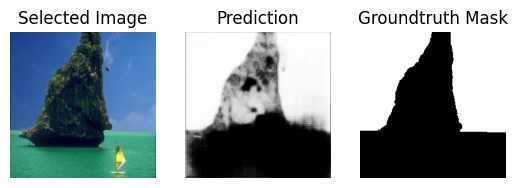

In [262]:
# Test Image
plt.subplot(1, 3, 1)
plt.title('Selected Image')
plt.imshow(test_img)
plt.axis('off')

# Predicted Mask
plt.subplot(1, 3, 2)
plt.title('Prediction')
plt.imshow(prediction.squeeze(), cmap='gray')  # Remove extra dimension
plt.axis('off')

# Ground Truth Mask
plt.subplot(1, 3, 3)
plt.title('Groundtruth Mask')
plt.imshow(gt_img, cmap='gray')  # Display the ground truth mask
plt.axis('off')

plt.show()

# 6. Evaluating U-Net's Segmentation

In [263]:
# Note: More information - https://medium.com/red-buffer/semantic-segmentation-u-net-1e5c0f4516a5
# Note: 256^2 = 65 536
# Note: Closer to 100% means better performance

## 6.x. Pixel Accuracy

In [264]:
# Note: Closer to 100% means better accuracy.

In [265]:
print("Predicted mask shape:", prediction.shape)
print("Ground truth mask shape:", gt_img.shape)

Predicted mask shape: (256, 256)
Ground truth mask shape: (256, 256)


In [266]:
# Compare binary segmentation mask with ground truth mask pixel by pixel
px_correct = np.sum(prediction == gt_img)

In [267]:
# Total number of pixels
px_total = np.prod(gt_img.shape)

In [268]:
# Compute pixel accuracy
eval_pa = px_correct / px_total * 100
print(px_correct, "/", px_total, "* 100")
# 65 536 = 256^2

16653 / 65536 * 100


In [269]:
print("Pixel Accuracy: {:.4f}%".format(eval_pa))

Pixel Accuracy: 25.4105%


## 6.x. Intersection over Union (IoU)

In [270]:
# Calculate intersection
intersection = np.sum(np.logical_and(prediction, gt_img))

In [271]:
# Calculate union
union = np.sum(np.logical_or(prediction, gt_img))

In [272]:
# Compute IoU
iou = intersection / union

In [273]:
print("Intersection over Union (IoU): {:.4f}".format(iou)) # closer to 100% means better segmentation performance

Intersection over Union (IoU): 0.6043


# 7. Visualizing Metrics w/ TensorBoard

In [248]:
!tensorboard --logdir=logs --host localhost --port 8088

2024-05-18 18:21:44.013853: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-18 18:21:45.657369: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
W0518 18:21:49.875244 15236 plugin_event_accumulator.py:369] Found more than one graph event per run, or there was a metagraph containing a graph_def, as well as one or more graph events.  Overwriting the graph with the newest event.
E0518 18:21:50.372375  8580 program.py:300] TensorBoard could not bind to port 8088, it was already in use
ERROR: TensorBoard could not bind to port 8088, it was already in use
